# Modelos

In [42]:
import IPython
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import scipy as sp
from statsmodels.graphics.gofplots import qqplot
from itertools import cycle, islice
import random

In [43]:
df = pd.read_csv("data.csv")

# Funcion que devuelve datos en un intervalo de tiempo dado
def filter_by_dates(begin,end,data):
    return data[data[data['dates']==begin].index[0]:data[data['dates']==end].index[0]]

#df = filter_by_dates('2005-01-31','2019-12-31',df)

In [44]:
# Codigo importado del notebook de analisis

interest_groups = df.columns[-10:-2]
continents = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
regions = [name for name in df.columns[250:272] if name not in continents]
interest_groups_df = df[interest_groups]
continents_df = df[continents]
regions_df = df[regions]
world_lapse=df.copy()
interest_groups_df_lapse=interest_groups_df.copy()
continents_df_lapse=continents_df.copy()
regions_df_lapse=regions_df.copy()
dfs=[world_lapse,interest_groups_df_lapse,continents_df_lapse,regions_df_lapse]
def time_group(lapse,n):
    labels=[]
    for i in range(1,int(np.ceil(n/lapse))+1):
        labels.extend(np.ones(lapse).astype(int)*i)
    return labels[0:n]
for each_df in dfs:
    each_df['Trimester']=time_group(3,len(each_df))
    each_df['Semester']=time_group(6,len(each_df))
    each_df['Year']=time_group(12,len(each_df))
    each_df['Lustrum']=time_group(60,len(each_df))
    each_df['Decade']=time_group(120,len(each_df))
world_data={'Month':df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    world_data[time_interval]=(world_lapse.groupby(time_interval).mean())[world_lapse.columns[1:285]]

interest_groups_data={'Month':interest_groups_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    interest_groups_data[time_interval]=(interest_groups_df_lapse.groupby(time_interval).mean())[interest_groups]
    
continents_data={'Month':continents_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    continents_data[time_interval]=(continents_df_lapse.groupby(time_interval).mean())[continents]
    
regions_data={'Month':regions_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    regions_data[time_interval]=(regions_df_lapse.groupby(time_interval).mean())[regions]
    
grouped_data={'World':world_data,
            'Interest Groups':interest_groups_data,
            'Continents':continents_data,
            'Regions':regions_data}

## Datos a usar

In [45]:
world_lapse.columns[1:249]

Index(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina',
       ...
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Wake Island',
       'Wallis and Futuna Islands', 'Western Sahara', 'Yemen', 'Yugoslav SFR',
       'Zambia', 'Zimbabwe', 'World'],
      dtype='object', length=248)

In [46]:
to_analyze = 'World'
group = 'World'
time_lapse = 'Month'

data = df[world_lapse.columns[1:249]]
#data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antarctica,Antigua and Barbuda,Argentina,...,Venezuela (Bolivarian Republic of),Viet Nam,Wake Island,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe,World
0,0.777,0.180,-1.022,0.565,-0.518,0.209,0.617,-1.807,0.656,-0.091,...,0.229,-0.404,NaN,0.917,-1.001,0.543,-0.020,0.172,-0.490,0.399
1,-1.743,-0.625,0.196,0.261,3.383,-0.545,0.382,-0.471,0.410,-0.077,...,-0.113,-0.137,NaN,0.010,1.181,0.139,0.878,-0.502,-0.487,0.263
2,0.516,0.995,-1.051,-0.831,1.559,0.170,0.004,-2.035,-0.265,-0.519,...,0.122,0.288,NaN,0.416,1.507,-0.128,1.885,0.137,0.506,0.254
3,-1.709,2.412,1.720,0.068,2.486,0.116,0.276,-1.477,0.000,-0.457,...,0.357,0.051,NaN,0.253,1.759,0.193,2.998,0.435,0.925,0.278
4,1.412,-0.515,1.863,0.133,0.545,0.786,0.218,0.497,0.116,1.045,...,0.750,-0.174,NaN,0.886,1.575,0.381,-0.978,1.299,1.995,0.367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,0.773,3.336,2.388,1.879,2.844,1.795,0.878,-0.134,1.049,0.426,...,1.261,1.474,0.714,1.523,1.281,NaN,NaN,1.605,1.882,1.201
704,2.004,2.706,2.192,1.658,1.951,0.534,1.034,-0.044,1.229,0.380,...,1.241,1.029,0.864,1.100,1.274,NaN,NaN,-0.781,0.059,1.415
705,1.264,3.004,2.076,1.504,2.749,1.230,0.966,0.466,0.859,0.516,...,0.920,1.559,NaN,1.404,2.516,NaN,NaN,1.662,2.009,1.545
706,-1.051,3.585,0.899,1.107,0.618,1.688,1.142,1.653,1.169,1.749,...,1.436,1.634,NaN,0.619,1.616,NaN,NaN,2.648,2.448,1.392


In [47]:
for column in data.columns:
    if data[column].isnull().values.any()==True:
        data=data.drop(column,axis=1)
data

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antarctica,Argentina,Australia,Austria,...,United Republic of Tanzania,United States of America,United States Virgin Islands,Uruguay,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Zimbabwe,World
0,0.777,0.180,-1.022,-0.518,0.209,0.617,-1.807,-0.091,0.287,-0.801,...,0.832,0.943,0.562,0.010,0.229,-0.404,0.917,-1.001,-0.490,0.399
1,-1.743,-0.625,0.196,3.383,-0.545,0.382,-0.471,-0.077,-0.002,2.903,...,-0.319,1.215,0.346,0.046,-0.113,-0.137,0.010,1.181,-0.487,0.263
2,0.516,0.995,-1.051,1.559,0.170,0.004,-2.035,-0.519,0.238,2.721,...,0.244,0.656,0.255,-0.293,0.122,0.288,0.416,1.507,0.506,0.254
3,-1.709,2.412,1.720,2.486,0.116,0.276,-1.477,-0.457,0.649,3.571,...,0.427,-1.210,0.527,-0.962,0.357,0.051,0.253,1.759,0.925,0.278
4,1.412,-0.515,1.863,0.545,0.786,0.218,0.497,1.045,-0.156,-1.180,...,1.025,-0.348,0.301,1.230,0.750,-0.174,0.886,1.575,1.995,0.367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,0.773,3.336,2.388,2.844,1.795,0.878,-0.134,0.426,0.434,3.264,...,2.177,1.018,0.761,-0.263,1.261,1.474,1.523,1.281,1.882,1.201
704,2.004,2.706,2.192,1.951,0.534,1.034,-0.044,0.380,1.252,1.269,...,1.752,2.021,0.911,0.012,1.241,1.029,1.100,1.274,0.059,1.415
705,1.264,3.004,2.076,2.749,1.230,0.966,0.466,0.516,2.119,2.758,...,1.076,-0.269,1.080,0.871,0.920,1.559,1.404,2.516,2.009,1.545
706,-1.051,3.585,0.899,0.618,1.688,1.142,1.653,1.749,1.202,2.526,...,1.550,0.514,1.107,2.158,1.436,1.634,0.619,1.616,2.448,1.392


In [48]:
most_correlated_temps=list(pd.DataFrame(data.corr().iloc[-1]).sort_values(by=['World'],ascending=False).index)
n_features=100
data=data[most_correlated_temps[:n_features+1]]

## Division de muestras

In [49]:
column_indices = {name: i for i, name in enumerate(data.columns)}
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]
num_features = df.shape[1]

## Ventana de los datos

In [50]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}   
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift    
        self.total_window_size = input_width + shift  
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] 
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [51]:
forecast=12
w1 = WindowGenerator(input_width=len(train_df)-forecast, label_width=forecast, shift=12,
                        label_columns=[to_analyze])
w1

Total window size: 495
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [52]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                        label_columns=[to_analyze])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['World']

## Separacion de ventana en inputs y etiquetas

In [53]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])    
    return inputs, labels

WindowGenerator.split_window = split_window

## Visualizacion de la ventana

In [54]:
def plot(self, model=None, plot_col=to_analyze, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(16, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)  
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index    
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)  
        if n == 0:
            plt.legend()    
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [55]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                            np.array(train_df[50:50+w2.total_window_size]),
                            np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 101)
Inputs shape: (3, 6, 101)
Labels shape: (3, 1, 1)


In [56]:
w2.example = example_inputs, example_labels

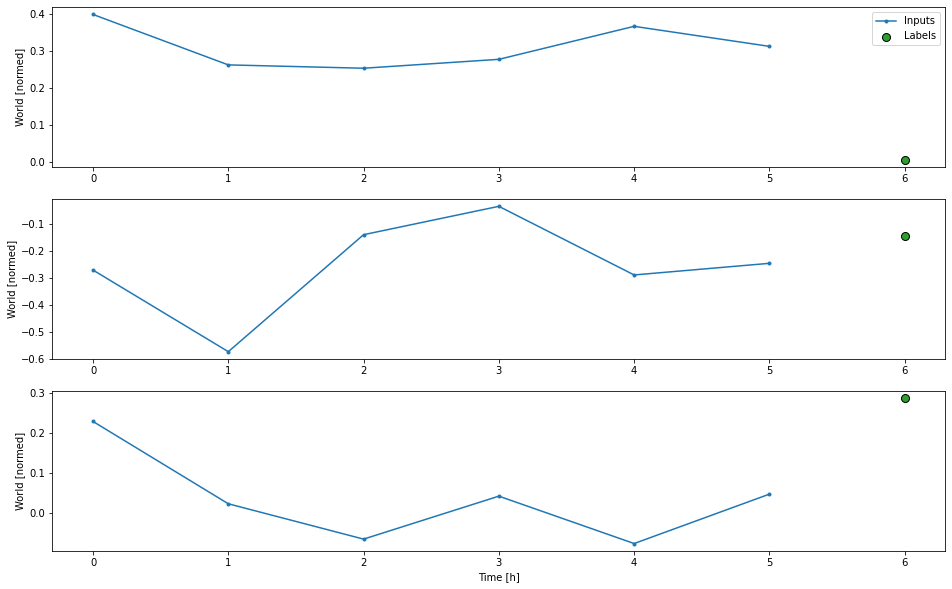

In [57]:

w2.plot()

In [58]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 495, 101)
Inputs shape: (1, 483, 101)
Labels shape: (1, 12, 1)


In [59]:
w1.example = example_inputs, example_labels

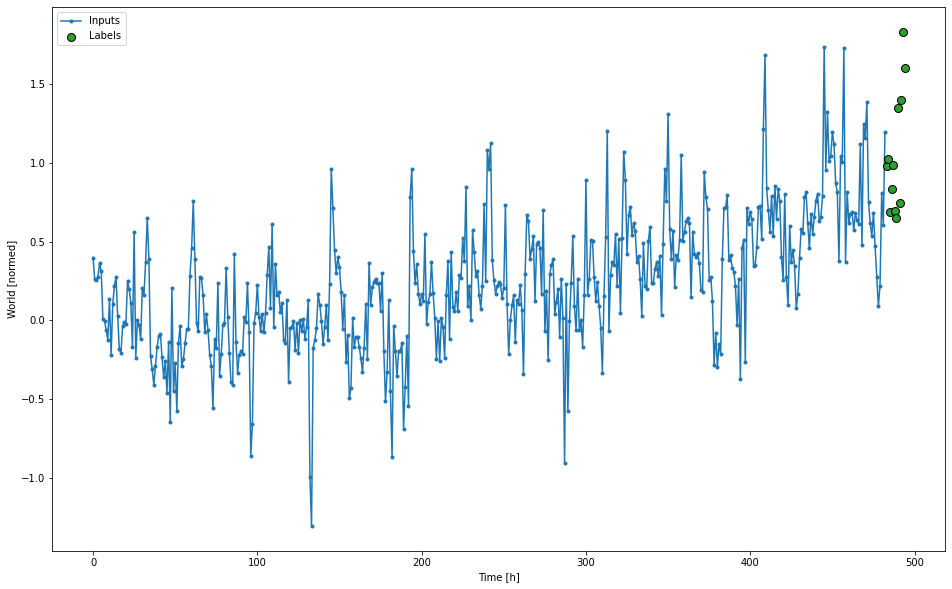

In [60]:
w1.plot()

## Se crea estructura de datos TF

In [61]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

## Se definen propiedades para acceder a TF

In [62]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [63]:
w1.train.element_spec

(TensorSpec(shape=(None, 483, 101), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))

## Ventana de un solo paso

In [64]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[to_analyze])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['World']

## Modelo base

In [65]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [66]:
single_step_window.val

<MapDataset shapes: ((None, 1, 101), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [67]:
baseline = Baseline(label_index=column_indices[to_analyze])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 1ms/step - loss: 0.1315 - mean_absolute_error: 0.2686


## Ventana amplia

In [68]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=[to_analyze])

wide_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['World']

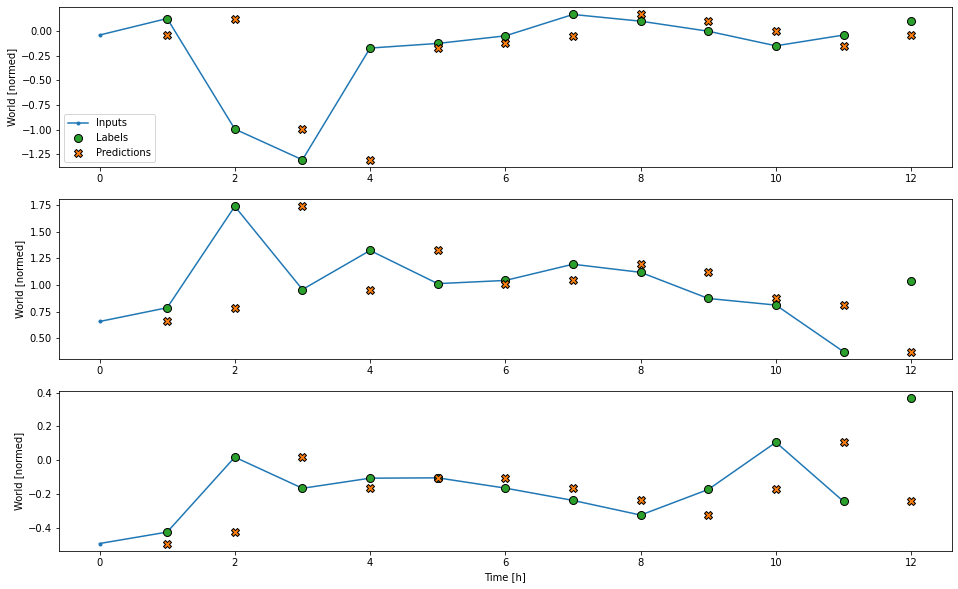

In [69]:
wide_window.plot(baseline)

## Graficas de aprendizaje

In [70]:
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

## Entrenamiento del modelo

In [71]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError()],
                )

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val,
                    callbacks=[early_stopping,PlotLearning()])
    return history

## Implementacion de modelos

## Ventana de entrenamiento

## Ventana convolucional

In [72]:
conv_forecast = 1

CONV_WIDTH = 140
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=conv_forecast,
    shift=1,
    label_columns=[to_analyze])

conv_window

Total window size: 141
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
Label indices: [140]
Label column name(s): ['World']

Text(0.5, 1.0, 'Given 483 months of inputs, predict 12 months into the future.')

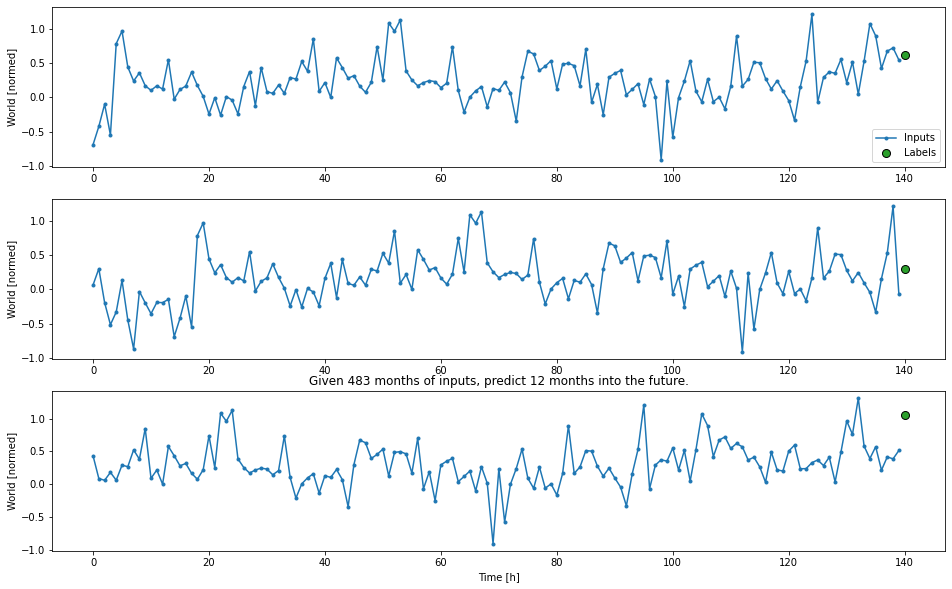

In [73]:
conv_window.plot()
plt.title("Given 483 months of inputs, predict 12 months into the future.")

## Resultados modelo base

In [74]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(conv_window.val)
performance['Baseline'] = baseline.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 128ms/step - loss: 0.1010 - mean_absolute_error: 0.2516


## CNN

## Modelo Convolucional

In [75]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                        kernel_size=(CONV_WIDTH,),
                        activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='sigmoid'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

### Ventana pequeña

In [76]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 46ms/step - loss: 0.0011 - mean_absolute_error: 0.0315


### Ventana amplia

In [77]:
LABEL_WIDTH = 140
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[to_analyze])

wide_conv_window

Total window size: 280
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

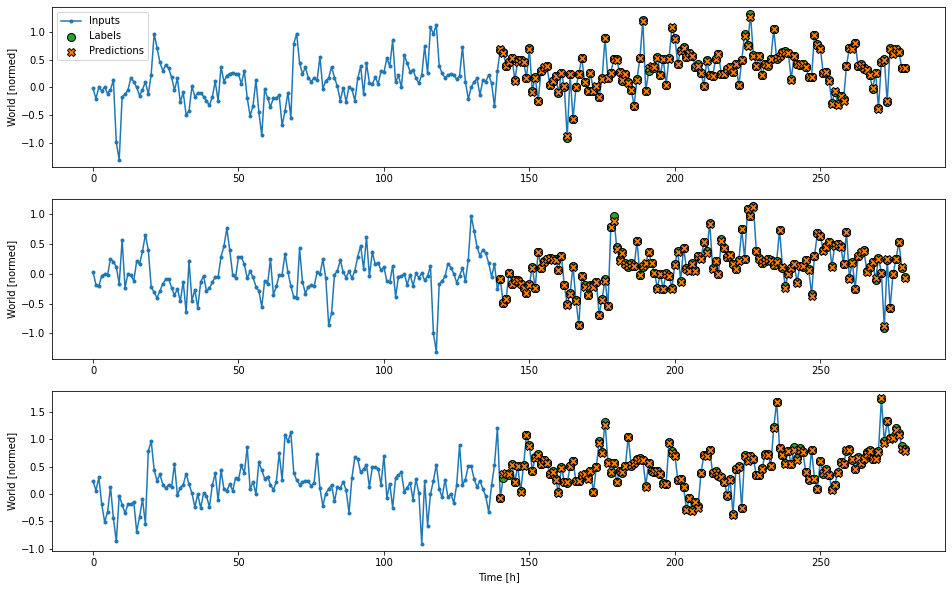

In [78]:
wide_conv_window.plot(conv_model)

## Exportación del modelo

In [82]:
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          452512    
                                                                 
 dense_6 (Dense)             (None, None, 64)          2112      
                                                                 
 dense_7 (Dense)             (None, None, 32)          2080      
                                                                 
 dense_8 (Dense)             (None, None, 16)          528       
                                                                 
 dense_9 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 457,249
Trainable params: 457,249
Non-trainable params: 0
_________________________________________________________________


In [83]:
conv_model.save("convolutional_model.h5")

In [85]:
loaded_model = tf.keras.models.load_model("convolutional_model.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          452512    
                                                                 
 dense_6 (Dense)             (None, None, 64)          2112      
                                                                 
 dense_7 (Dense)             (None, None, 32)          2080      
                                                                 
 dense_8 (Dense)             (None, None, 16)          528       
                                                                 
 dense_9 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 457,249
Trainable params: 457,249
Non-trainable params: 0
_________________________________________________________________


In [115]:
prediction_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[to_analyze])

prediction_window

Total window size: 280
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

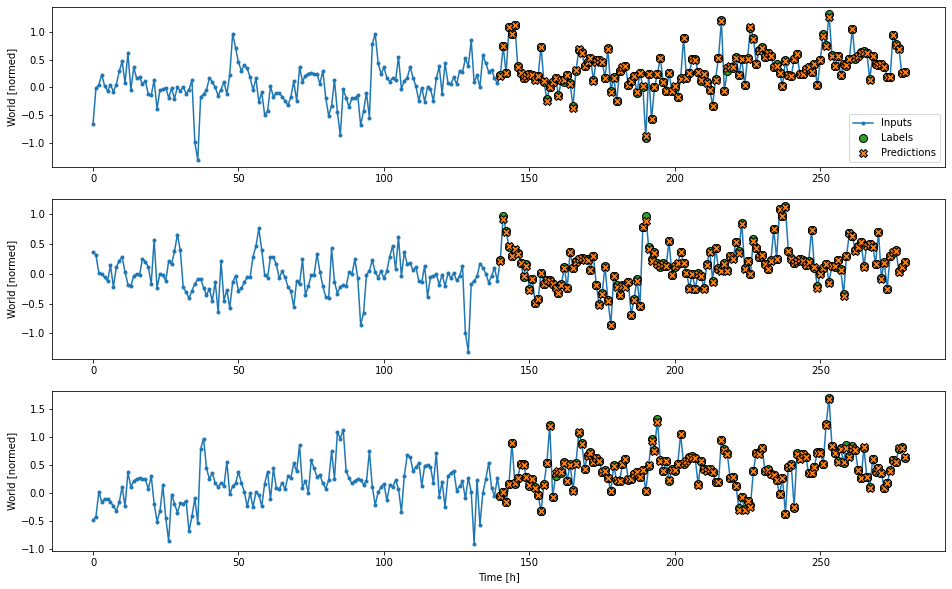

In [116]:
prediction_window.plot(loaded_model)

## RNN

## Modelo Long Short-Term Memory

In [79]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),

    tf.keras.layers.Dense(units=16,activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

### Ventana amplia

In [80]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 1ms/step - loss: 0.1608 - mean_absolute_error: 0.3276


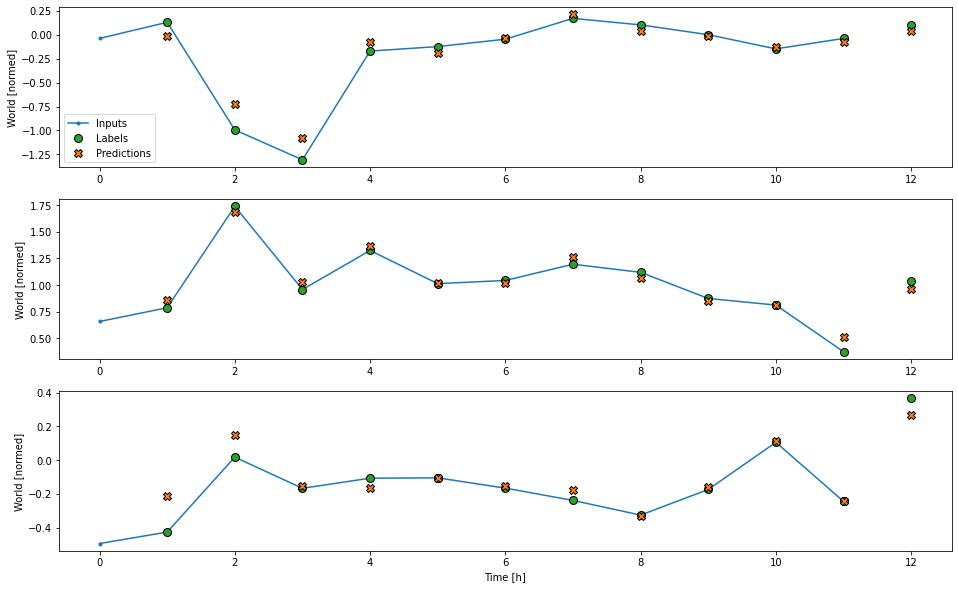

In [81]:
wide_window.plot(lstm_model)